In [3]:
import matplotlib_inline.backend_inline
from matplotlib import pyplot as plt
from astropy.table import Table
from astropy.io import fits
from pathlib import Path
import numpy as np
import eazy
import pickle
import gc
import os
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 25

WD = Path('/data1/hbahk/spherex-photoz/spherex-challenge/joint_challenge')
os.chdir(WD)
TEMPDIR = WD.parent / 'BROWN_COSMOS'

from utils import fit_and_save_result_prior

params = {}
params["FILTERS_RES"] = "data/filters/FILTER.RES+SPHEREx+7DT_reduced.res"
params["TEMPLATES_FILE"] = "BROWN_COSMOS.template"
params["TEMP_ERR_FILE"] = "../template_error_cosmos2020.txt"
params["TEMP_ERR_A2"] = 0.0  # nullify the template error

params["SYS_ERR"] = 0.01

params["MW_EBV"] = 0.016577
params["CAT_HAS_EXTCORR"] = False

params["MAIN_OUTPUT_FILE"] = "output"

params["APPLY_PRIOR"] = True
params["PRIOR_FILE"] = "../prior_K_TAO.dat"
params["PRIOR_FILTER"] = 466  # SPHEREx band corresponding to the K-band
params["PRIOR_ABZP"] = 23.9
params["PRIOR_FLOOR"] = 0.01

params["FIX_ZSPEC"] = False
params["Z_MIN"] = 0.002
params["Z_MAX"] = 5.8
params["Z_STEP"] = 0.01
params["Z_STEP_TYPE"] = 1

translate_filename = "dummy.translate"

params["CATALOG_FILE"] = "data/input/GAMA_input_7DS_IMS.fits"
dir_output = WD / "output" / "output_GAMA_7DS_IMS"
dir_output.mkdir(parents=True, exist_ok=True)
params["OUTPUT_DIRECTORY"] = dir_output.as_posix()
params["PRIOR_FILE"] = "../prior_R_zmax7.dat"
params["PRIOR_FILTER"] = 531  # 7DT band corresponding to the R-band
params_GAMA_7DS_IMS = params.copy()

In [4]:
from utils import fit_catalog_single_template, fit_at_zbest_single_template

with open("data/tempfilt_7DS.pickle", "rb") as rfile:
    tempfilt_7DS = pickle.load(rfile)

params = params_GAMA_7DS_IMS.copy()

base = Table.read(params["CATALOG_FILE"])
    
Ncat = len(base)
Nbatch = np.ceil(Ncat / 10000).astype(int)

multiple_fluxerr = 1.5
for colname in base.colnames:
    if colname.startswith("E"):
        base[colname] *= multiple_fluxerr
            
params["CATALOG_FILE"] = base


ez = eazy.photoz.PhotoZ(
    param_file=None,
    translate_file=translate_filename,
    zeropoint_file=None,
    params=params,
    tempfilt=tempfilt_7DS,
)

ez.ZML_WITH_PRIOR = True
fit_catalog_single_template(ez, ez.idx, n_proc=40, prior=True)
ez.ZML_WITH_PRIOR = True
fit_at_zbest_single_template(ez, prior=True, nproc=1)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Read default param file: /data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/data/zphot.param.default
CATALOG_FILE is a table
   >>> NOBJ = 44124
F521 E521 (521): 7DT_4000_fitted
F522 E522 (522): 7DT_4250_fitted
F523 E523 (523): 7DT_4500_fitted
F524 E524 (524): 7DT_4750_fitted
F525 E525 (525): 7DT_5000_fitted
F526 E526 (526): 7DT_5250_fitted
F527 E527 (527): 7DT_5500_fitted
F528 E528 (528): 7DT_5750_fitted
F529 E529 (529): 7DT_6000_fitted
F530 E530 (530): 7DT_6250_fitted
F531 E531 (531): 7DT_6500_fitted
F532 E532 (532): 7DT_6750_fitted
F533 E533 (533): 7DT_7000_fitted
F534 E534 (534): 7DT_7250_fitted
F535 E535 (535): 7DT_7500_fitted
F536 E536 (536): 7DT_7750_fitted
F537 E537 (537): 7DT_8000_fitted
F538 E538 (538): 7DT_8250_fitted
F539 E539 (539): 7DT_8500_fitted
F540 E540 (540): 7DT_8750_fitted
Set sys_err = 0.01 (positive=True)


/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:975: RuntimeWarning: overflow encountered in square
  efnu = np.sqrt(self.efnu_orig**2 +
/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:976: RuntimeWarning: overflow encountered in square
  (self.param['SYS_ERR']*np.maximum(self.fnu, 0.))**2)
/data1/hbahk/envs/main/lib/python3.9/site-packages/eazy/photoz.py:1326: RuntimeWarning: invalid value encountered in log10
  self.prior_mag_cat += -2.5*np.log10(np.squeeze(self.fnu[:,ix]))


Read PRIOR_FILE:  ../prior_R_zmax7.dat


192it [00:01, 132.00it/s]
100%|██████████| 192/192 [00:31<00:00,  6.02it/s]


fit_best: 3.8 s (n_proc=4,  NOBJ=43879)
fit_best: 2.7 s (n_proc=4,  NOBJ=43879)


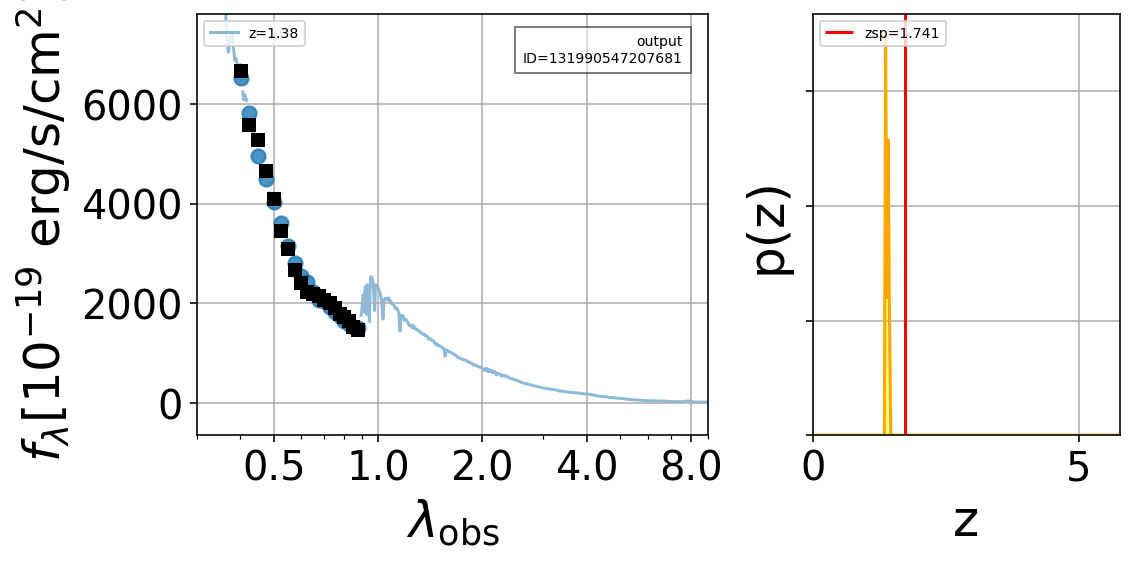

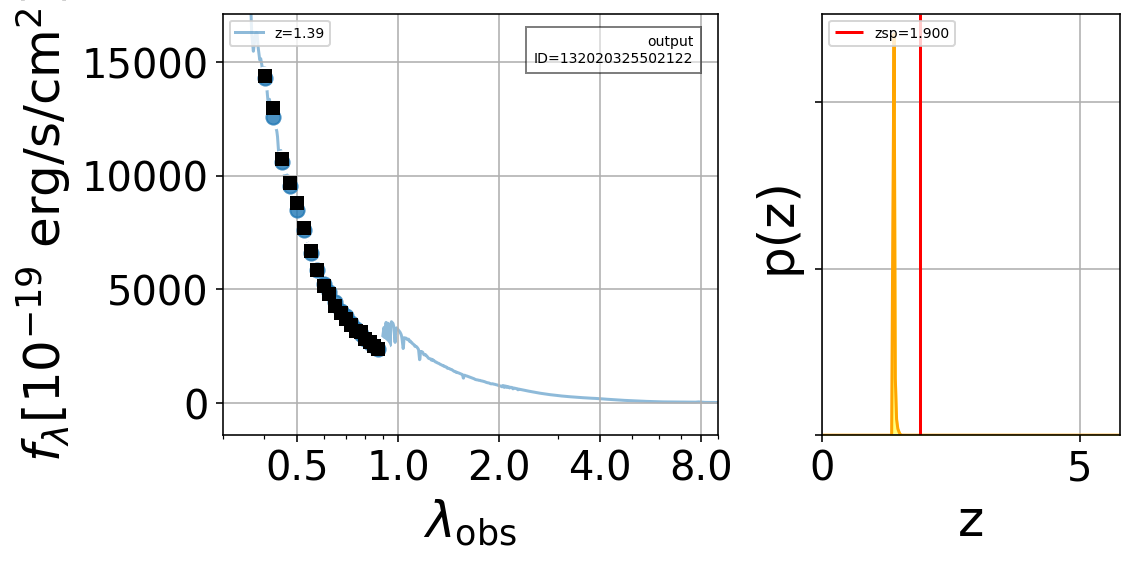

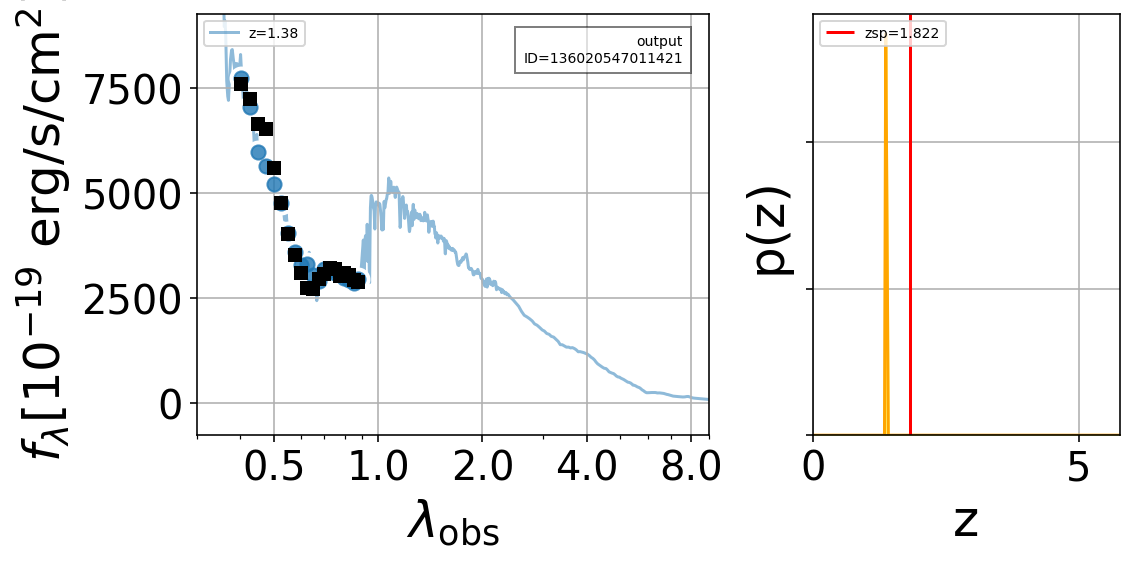

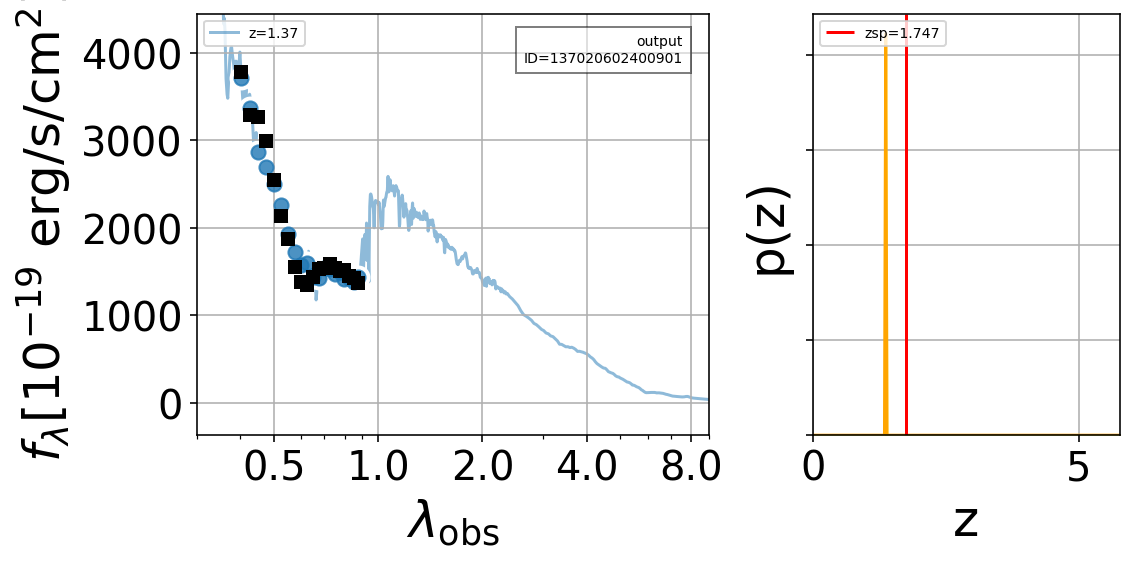

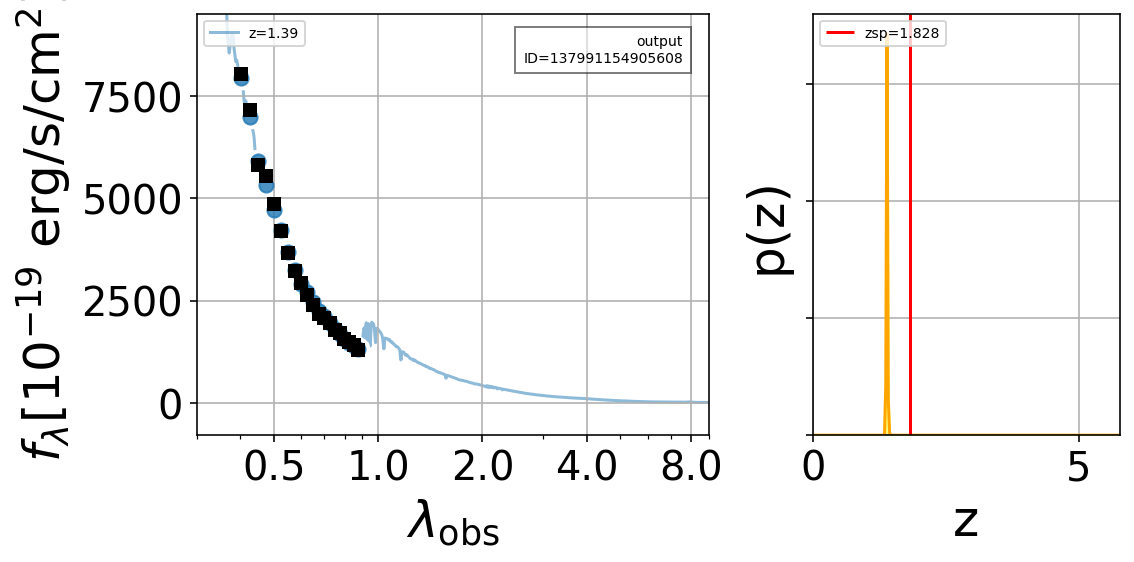

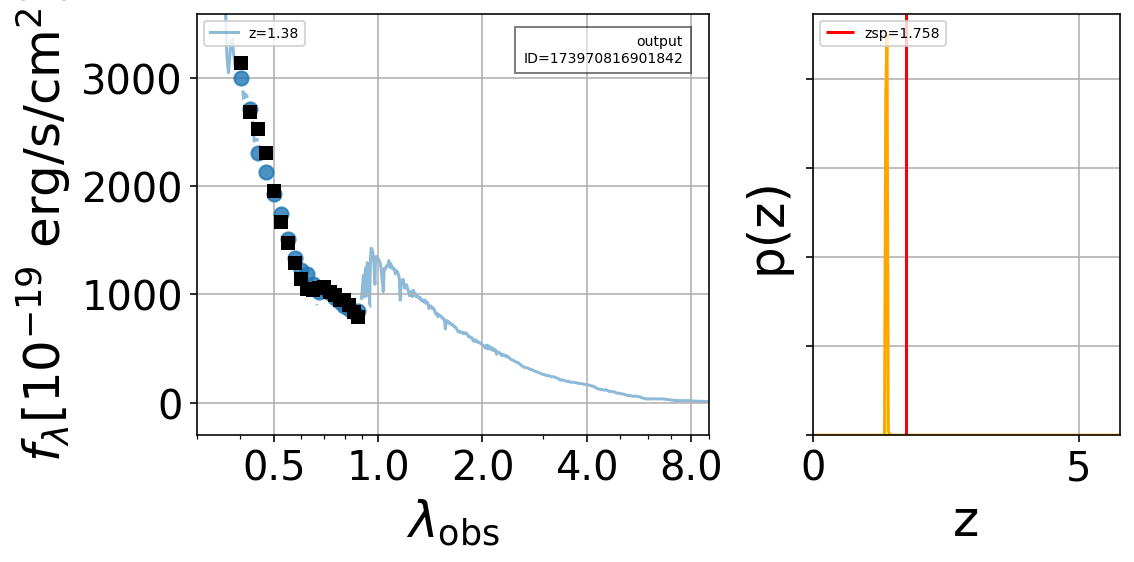

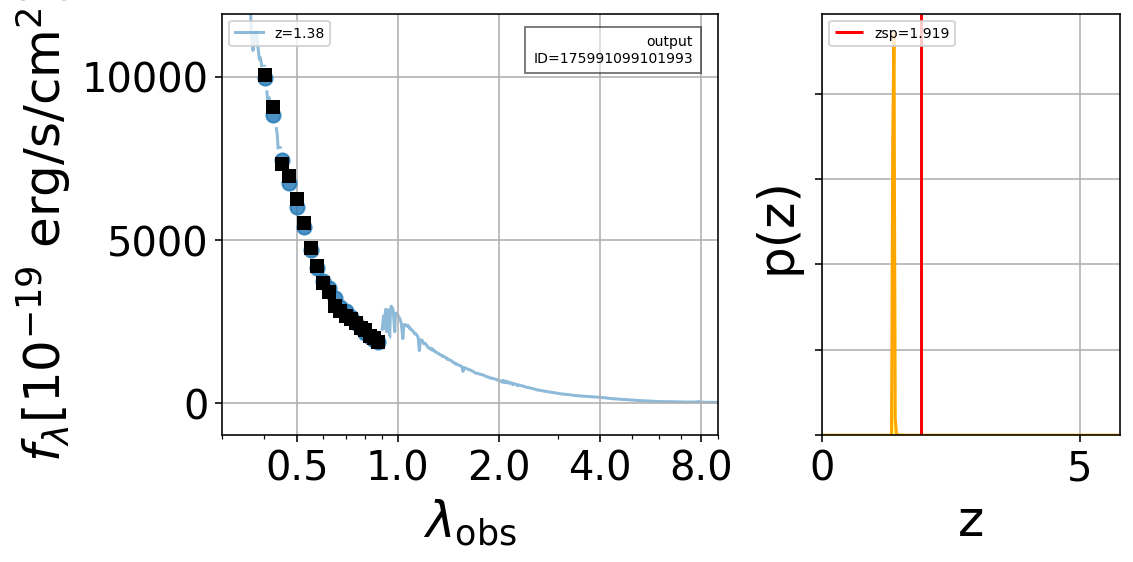

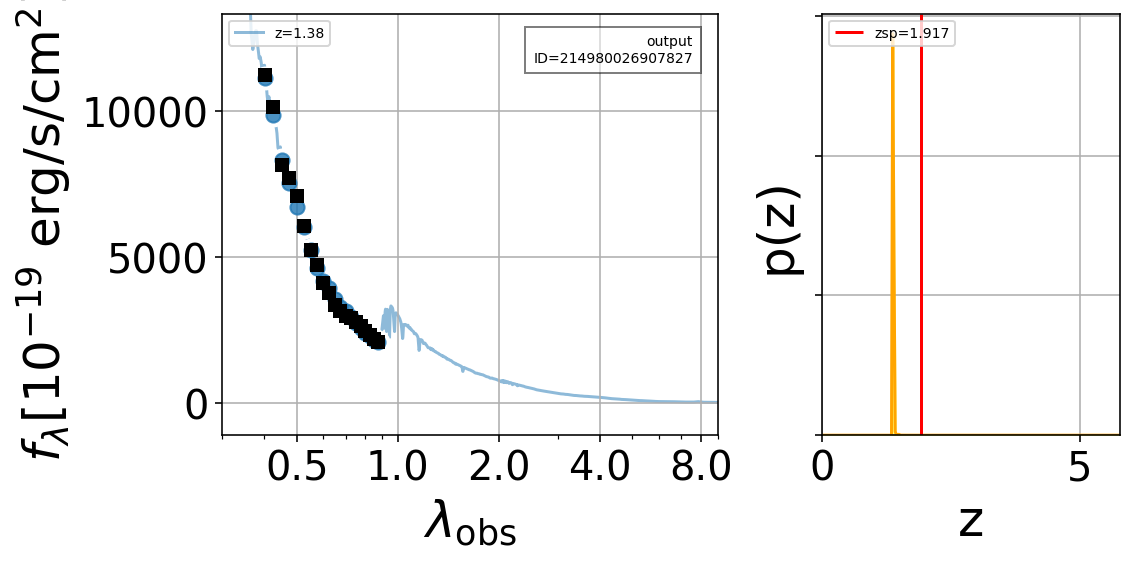

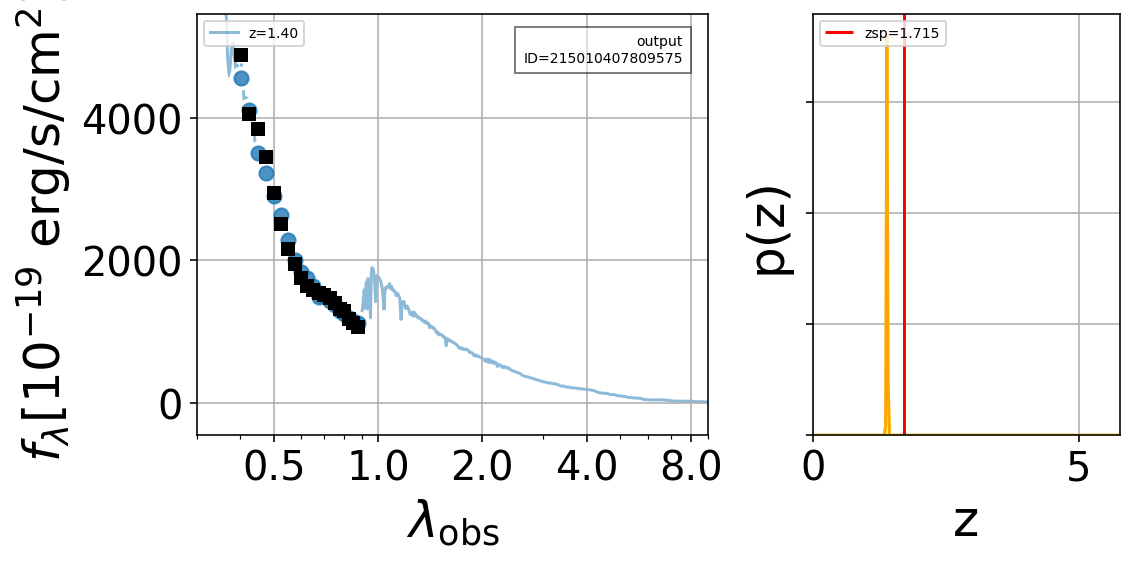

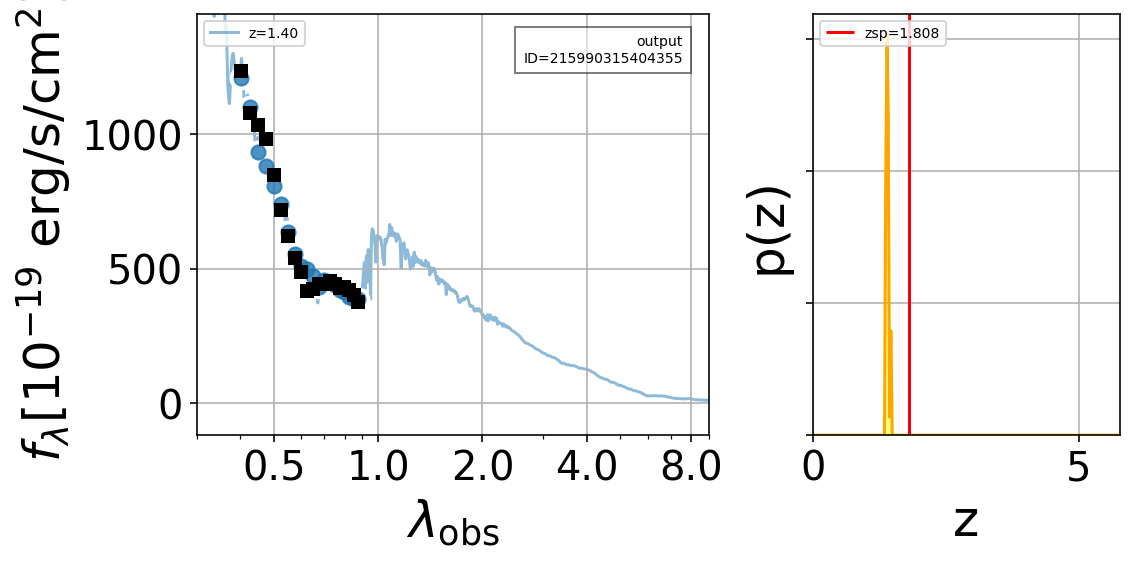

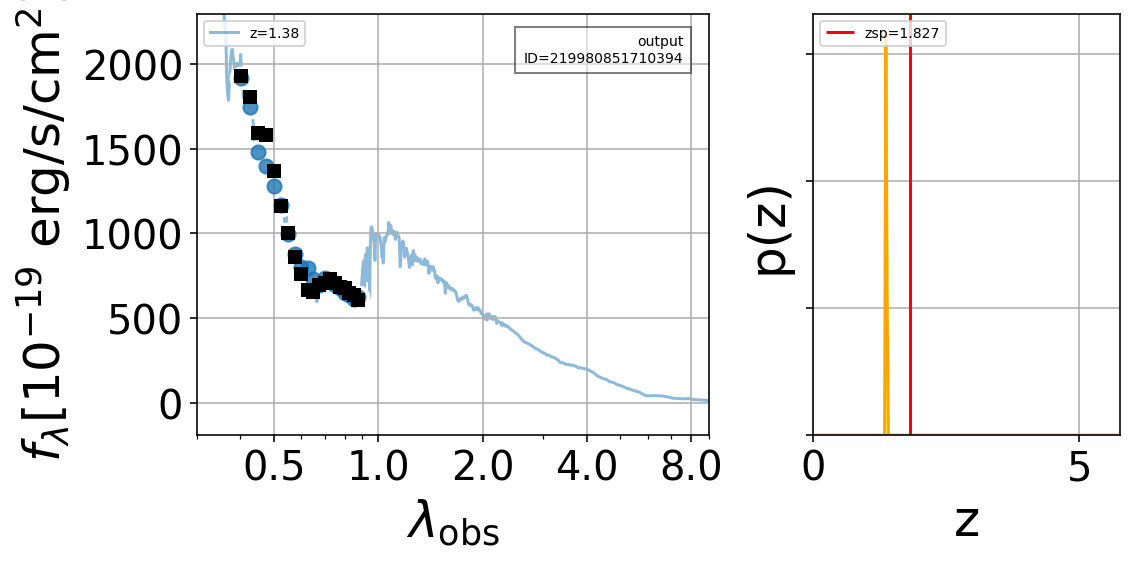

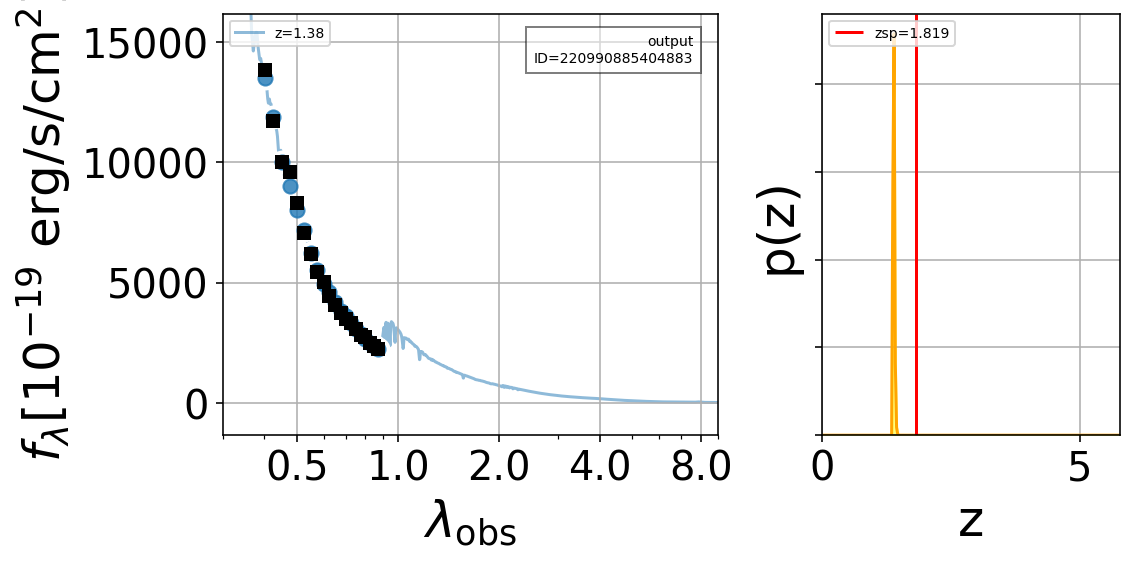

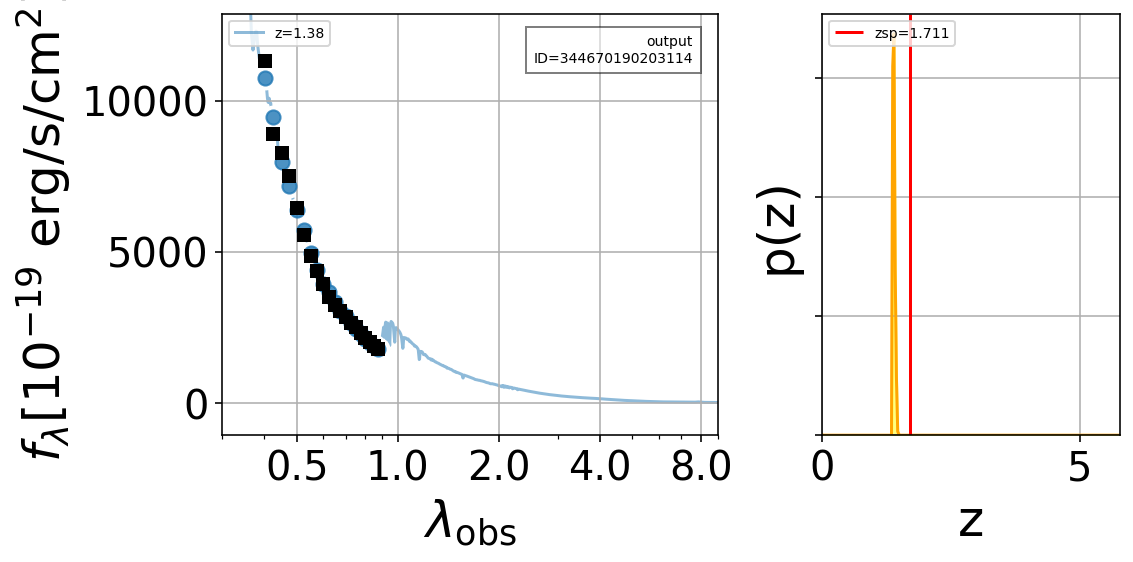

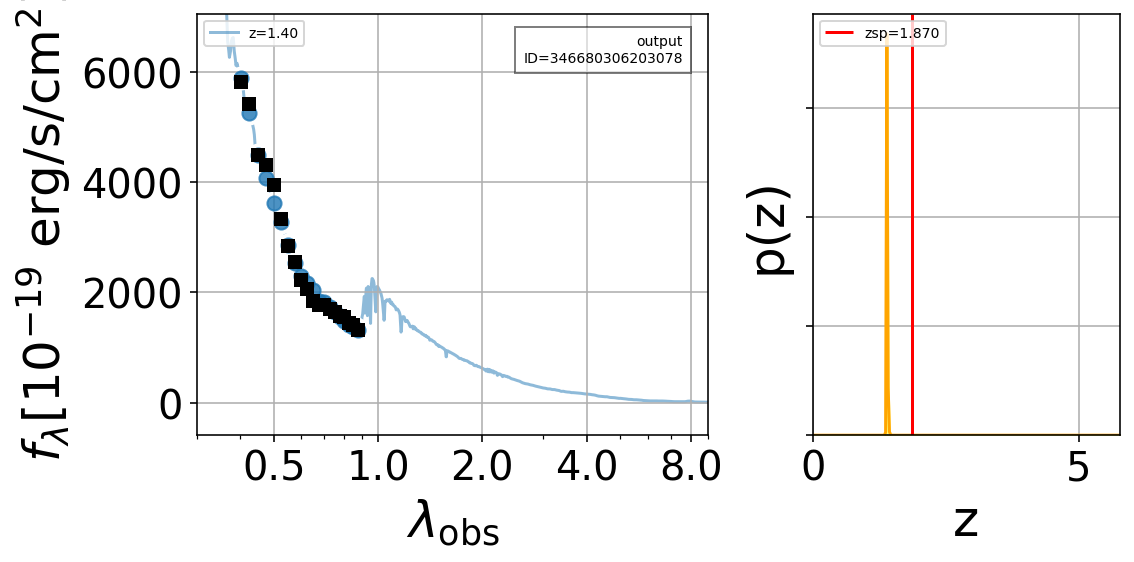

In [7]:
from utils import show_fit_single_template

selection = (ez.ZSPEC > 1.7) & (ez.ZSPEC < 2) & (ez.zbest < 1.4) & (ez.zbest > 1.2)

ids = ez.idx[selection]

for idx in ids:
    show_fit_single_template(ez, idx, tempfilt_7DS)